# PyGPlates
In this notebook we will explore the use of Python as an interface for the paleomagnetism and plate-reconstruction software [GPlates](https://www.gplates.org/) using PyGPlates and [GPlately](https://github.com/GPlates/gplately).

This software provides paleomagnetists with an invaluable set of tools for modelling the movement of plates. For geologists PyGPlates enables the reconstruction of paleogeography, helping users visualize how continents and oceans have evolved over millions of years and allows understanding our samples in their geologic and geographic context of formation. Users can analyze geological data in the context of plate tectonics, understanding the spatial relationships between geological features and plate boundaries.

There are many advantages for using a programming interface for GPlates, rather than the GUI. Such as leveraging Python's extensive data analysis capabilities, advanced and more customisable visualisation and creation of workflows for batch processing.


First step is to install pygmt and gplately on our virtual machine

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Install 'condacolab' and suppress output
!pip install -q condacolab > /dev/null 2>&1
import condacolab
condacolab.install()  # This line may still produce output depending on how 'install()' is implemented

# Install 'pygmt' and 'gplately' using 'mamba', and suppress output
!mamba install pygmt > /dev/null 2>&1
!mamba install gplately > /dev/null 2>&1


⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


import the libraries

In [ ]:
import sys
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Redirect stdout and stderr to null
original_stdout = sys.stdout
original_stderr = sys.stderr
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import pygplates
import gplately
import pygmt

# Restore stdout and stderr
sys.stdout = original_stdout
sys.stderr = original_stderr

from shapely.validation import make_valid
import ptt

## GPlates Files
The classic approach using the older versions of PyGPlates would be to import files from a local directory. GPlately allows us to retrieve files hosted in a remote data server. Retrieving from the remote server are that you don't necessarily need to have the files stored anywhere and download them on the fly. However, you are limited to the files that are stored in the server. If you want to use alternate reconstructions you need to use local files. For this workshop we'll use the plate reconstruction model of [Merdith et al. 2021](https://www.sciencedirect.com/science/article/pii/S0012825220305237), so we can use the data server approach.

The two type of GPlates files we'll be using are:


1. Rotation file (*.rot)

In the context of GPlates, a rotation file is a data file that contains information about the relative motion and rotation of tectonic plates over geological time. Rotation files are a crucial component of plate tectonic reconstructions and are used to model the movement of geological features (such as continents, ocean basins, and mountain ranges) through time. Rotation files will contain information about how different plates (identified with **plate IDs**) move relative to each other according to a **rotation pole** during a set **time interval**. The amount of rotation along the pole for the time interval is given by the **rotation angle**.


2. Gpml files (*.gpml)

A .gpml file, short for GPlates Markup Language file, is a specific file format used by GPlates, a plate tectonics software, for storing and exchanging geological and geophysical data. These files are written in XML (eXtensible Markup Language) format. The XML structure of a .gpml file is hierarchical, organizing data into nested elements and attributes. This structure allows for the representation of complex geological information. Elements in .gpml files can have attributes that provide additional information or metadata about the represented features. Metadata might include information about the age of a geological feature, the publication source, or the geological time period it represents.

In summary, gpml files serve as a standard data format for storing geological and geophysical information in the realm of plate tectonics research. They facilitate data exchange, analysis, and visualization within the GPlates software environment and promote interoperability among scientists working on understanding Earth's dynamic geological history. We can convert shape files into gpml files



In [ ]:
import sys

# Temporarily redirect stdout and stderr to null
original_stdout = sys.stdout
original_stderr = sys.stderr
sys.stdout = open('/dev/null', 'w')
sys.stderr = open('/dev/null', 'w')

# Call GPlately's DataServer from the download.py module
download = gplately.download.DataServer("Merdith2021")

# Obtain all rotation files, topology features, and static polygons from Merdith et al. 2021
rotation_model, topology_features, static_polygons = download.get_plate_reconstruction_files()

# Restore stdout and stderr to their original values
sys.stdout = original_stdout
sys.stderr = original_stderr


We must define our reconstruction model with the `gplately.PlateReconstruction()` function. It takes the rotation model, the topology features, and the static polygons (plate shapes) as arguments. Topology features are the shapes of ridges, trenches and transforms. Static polygons are current polygons with unchanging shapes over geological time. They serve as templates to categorise dynamic polygons into recognisable topological plates (each assigned a unique ID) based on their present-day positions.

In [ ]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Helper function to plot subduction with teeth pointing in the right direction using PyGMT:

In [ ]:
# Define the function 'plot_subduction' with parameters 'df', 'fig_object', 'color', and 'side'
def plot_subduction(df, fig_object, color="black", side="l"):

    # Use the 'plot' method of the 'fig_object' to plot the data in 'df'
    fig_object.plot(
        df,  # Data to be plotted
        pen=f"1p,{color}",
        # Specifies the pen style: '1p' sets the pen width, '{color}' sets the pen color
        style=f"f0.5c/0.15c+{side}+t",
        # Defines the style of the plot with various styling options
        # 'f': fault symbol, '0.5c': length, '0.15c': width, '{side}': side ('l' or 'r'), 't': terminal symbol
        fill=color  # Fills the plotted area with the specified color
    )


Now we must instantiate the model to reconstruct features to our desired time. We retrieve the reconstructable geometries (coastlines and continents) and use the model to calculate the positions and behaviour of the topological features, as well as the positions of the polygons at the desired time.

In [ ]:
time = 270 #Ma
# Get geometry files
coastlines, continents, COB = download.get_topology_geometries()
SZ_info = model.tessellate_subduction_zones(time, ignore_warnings=True)
ridge_info = model.tessellate_mid_ocean_ridges(time, ignore_warnings=True)


gplot = gplately.PlotTopologies(model, coastlines=coastlines, continents=continents, time=time)


# Retrieve the geometries as GeoDataFrames
RT = gplot.get_ridges_and_transforms()
SZ_L = a = gplot.get_subduction_direction()[0]
SZ_R = a = gplot.get_subduction_direction()[1]
coastlines = gplot.get_coastlines()
continents = gplot.get_continents()

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.


In [ ]:
continents

Below is an adaptation of the gplately function to calculate the velocity vectors

In [ ]:
def plate_motion_vectors(
        rotation_model, topologies, time, spacingX=10, spacingY=10, normalise=False, **kwargs
    ):
  lons = np.arange(-180, 180 + spacingX, spacingX)
  lats = np.arange(-90, 90 + spacingY, spacingY)
  lonq, latq = np.meshgrid(lons, lats)

  # create a feature from all the points
  velocity_domain_features = ptt.velocity_tools.make_GPML_velocity_feature(
    lonq.ravel(), latq.ravel()
  )

  rotation_model = rotation_model
  topology_features = topologies

  delta_time = 5.0
  all_velocities = ptt.velocity_tools.get_plate_velocities(
    velocity_domain_features,
    topology_features,
    rotation_model,
    time,
    delta_time,
    "vector_comp",
  )

  X, Y, U, V = ptt.velocity_tools.get_x_y_u_v(lons, lats, all_velocities)
  X,Y = np.meshgrid(X,Y)

  if normalise:
    mag = np.hypot(U, V)
    mag[mag == 0] = 1
    U /= mag
    V /= mag

  X = X.flatten()
  Y = Y.flatten()
  U = U.flatten()
  V = V.flatten()

  df = pd.DataFrame({
      'X':X,
      'Y':Y,
      'E_velocity':U,
      'N_velocity':V
  })


  return df

In [ ]:
vec = plate_motion_vectors(
    rotation_model,topology_features,time,normalise=True
)

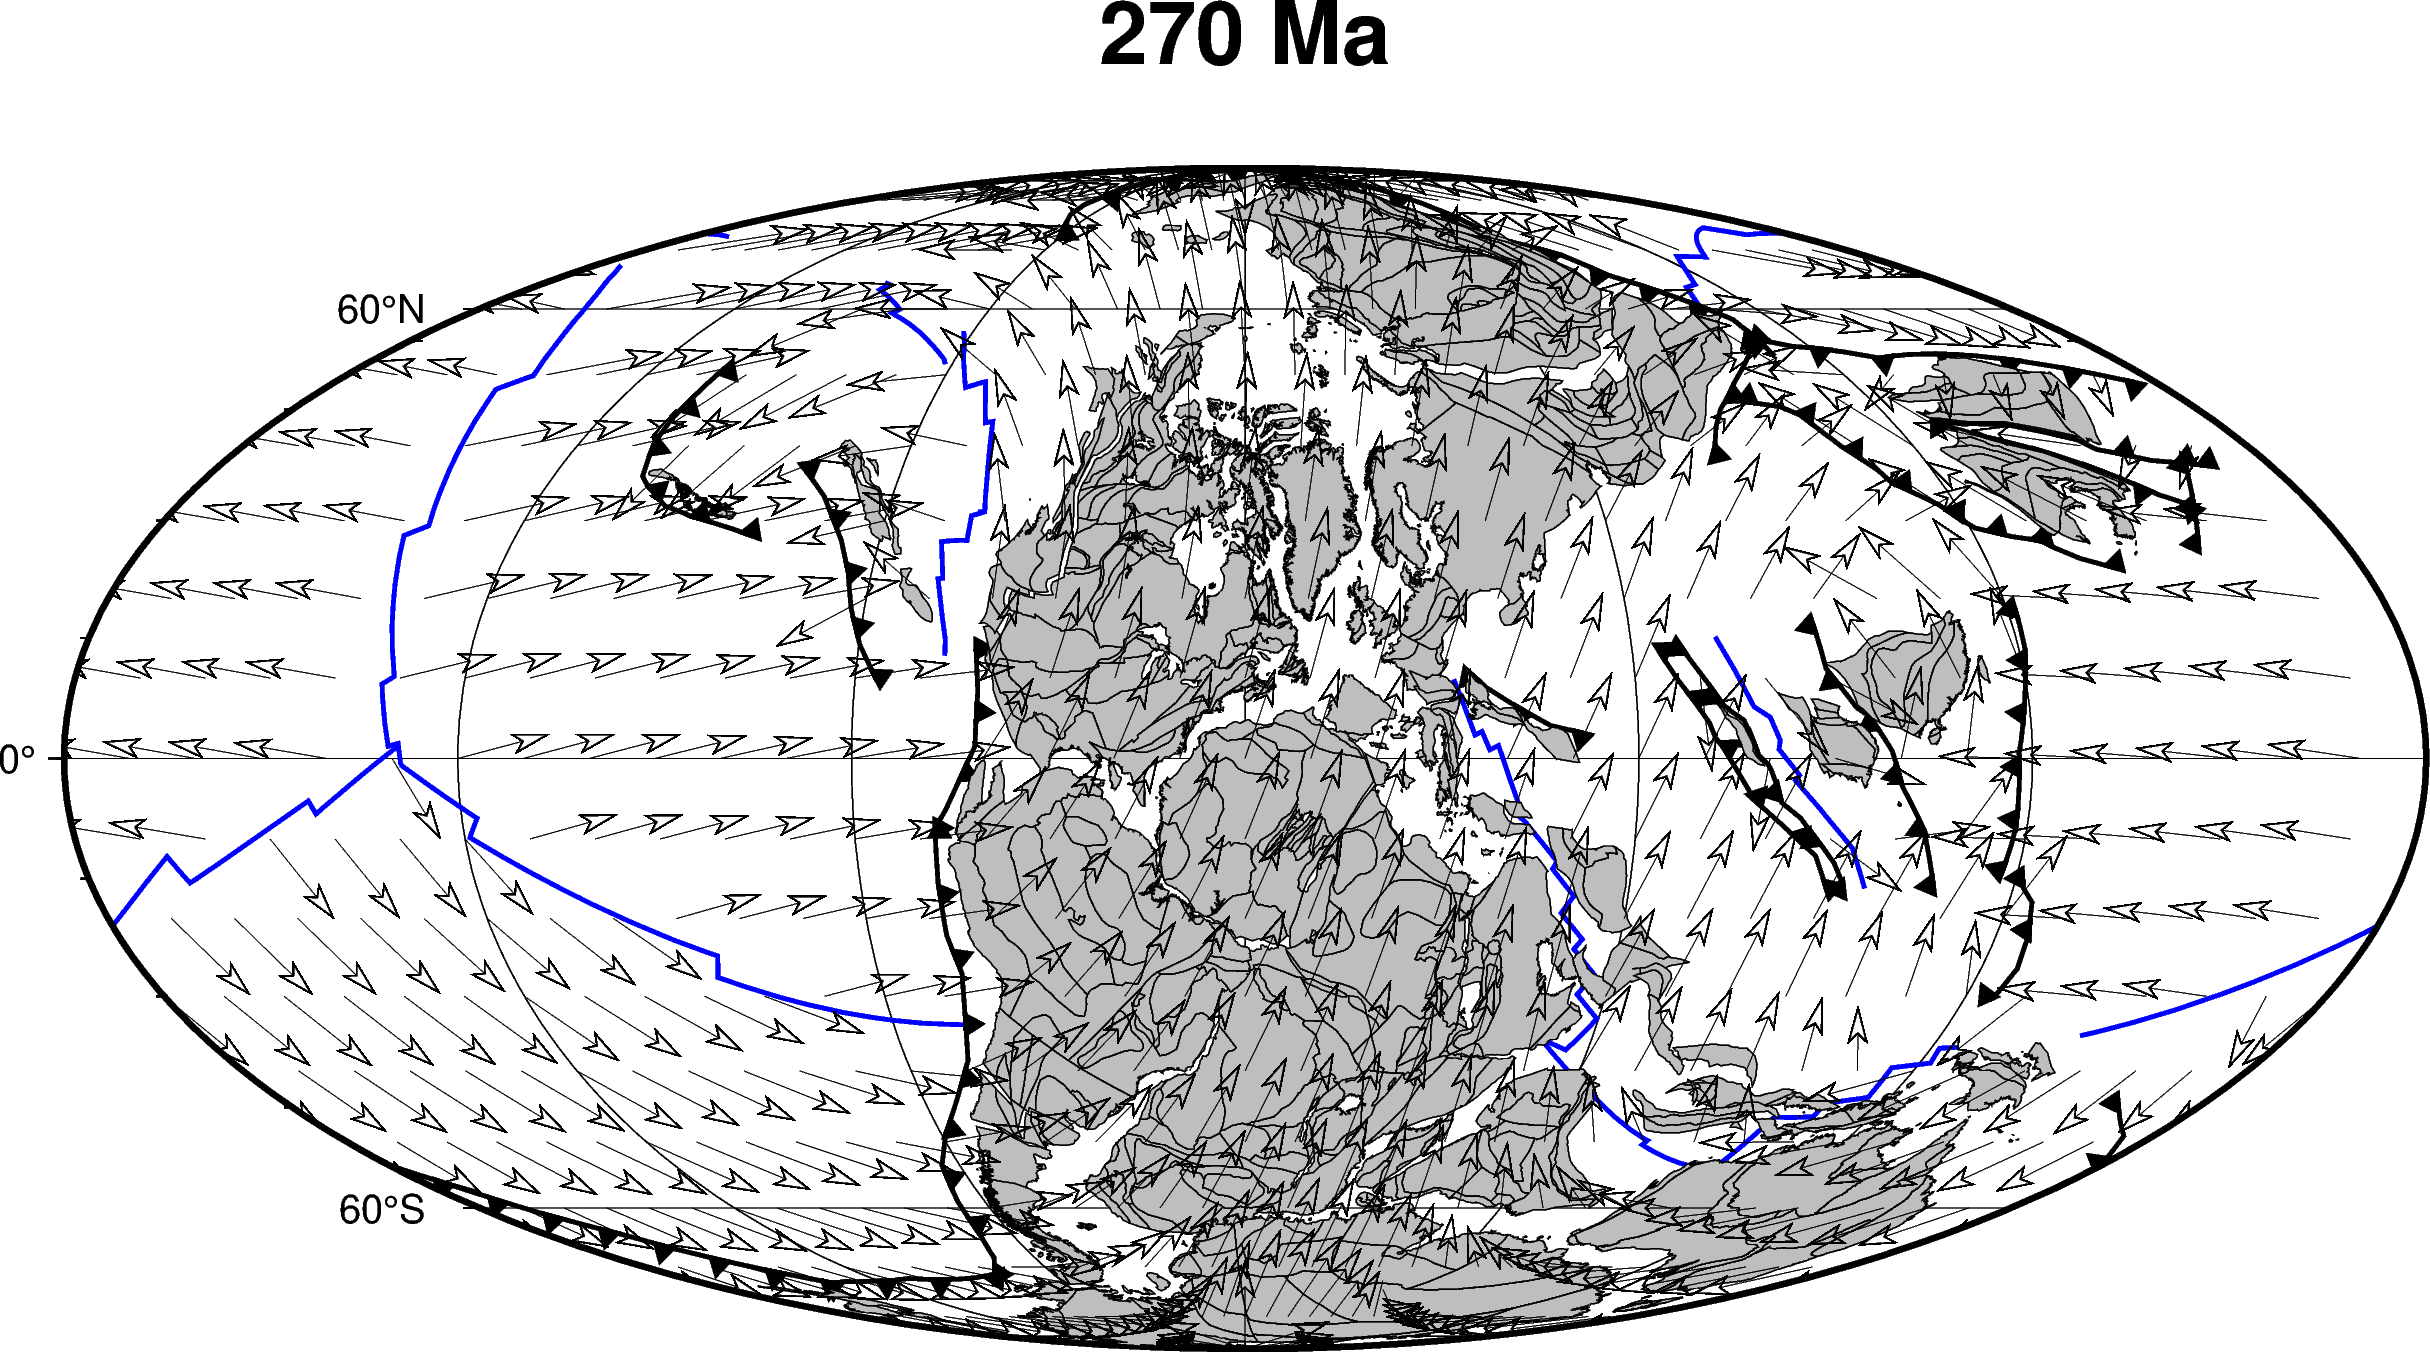

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fig = pygmt.Figure()


fig.plot(
    RT.geometry,
    pen="1p,blue",
    region="d",
    projection="W20c",
    frame=["afg",f"+t{time} Ma"]
)


plot_subduction(SZ_L,fig)
plot_subduction(SZ_R,fig,side="r")



fig.plot(
    coastlines,
    fill="gray",
    pen="thinnest"
)

fig.velo(
    data=vec,
    pen="0.6p,black",
    spec="e0.8/0.9"
)


fig.show()

# Working with Point Data

One of the main uses of plate reconstructions for geologists is reconstructing the location of point data (sample locations, geochemical analyses, fossil sites). We can do that easily with gplately and the model we had already set up. Below we'll load a dataset with locations of samples from Permian CFB provinces compiled from GEOROC.

In [ ]:
import warnings
import pandas as pd
import geopandas as gpd

warnings.filterwarnings('ignore')

CFB = pd.read_excel(r"https://raw.githubusercontent.com/pierosampaio/PythonWorkshop/main/" +
                    "Files/GPlates_files/All_Perm_CFB.xlsx")

CFB = gpd.GeoDataFrame(CFB, geometry=gpd.points_from_xy(CFB.LONGITUDE, CFB.LATITUDE))


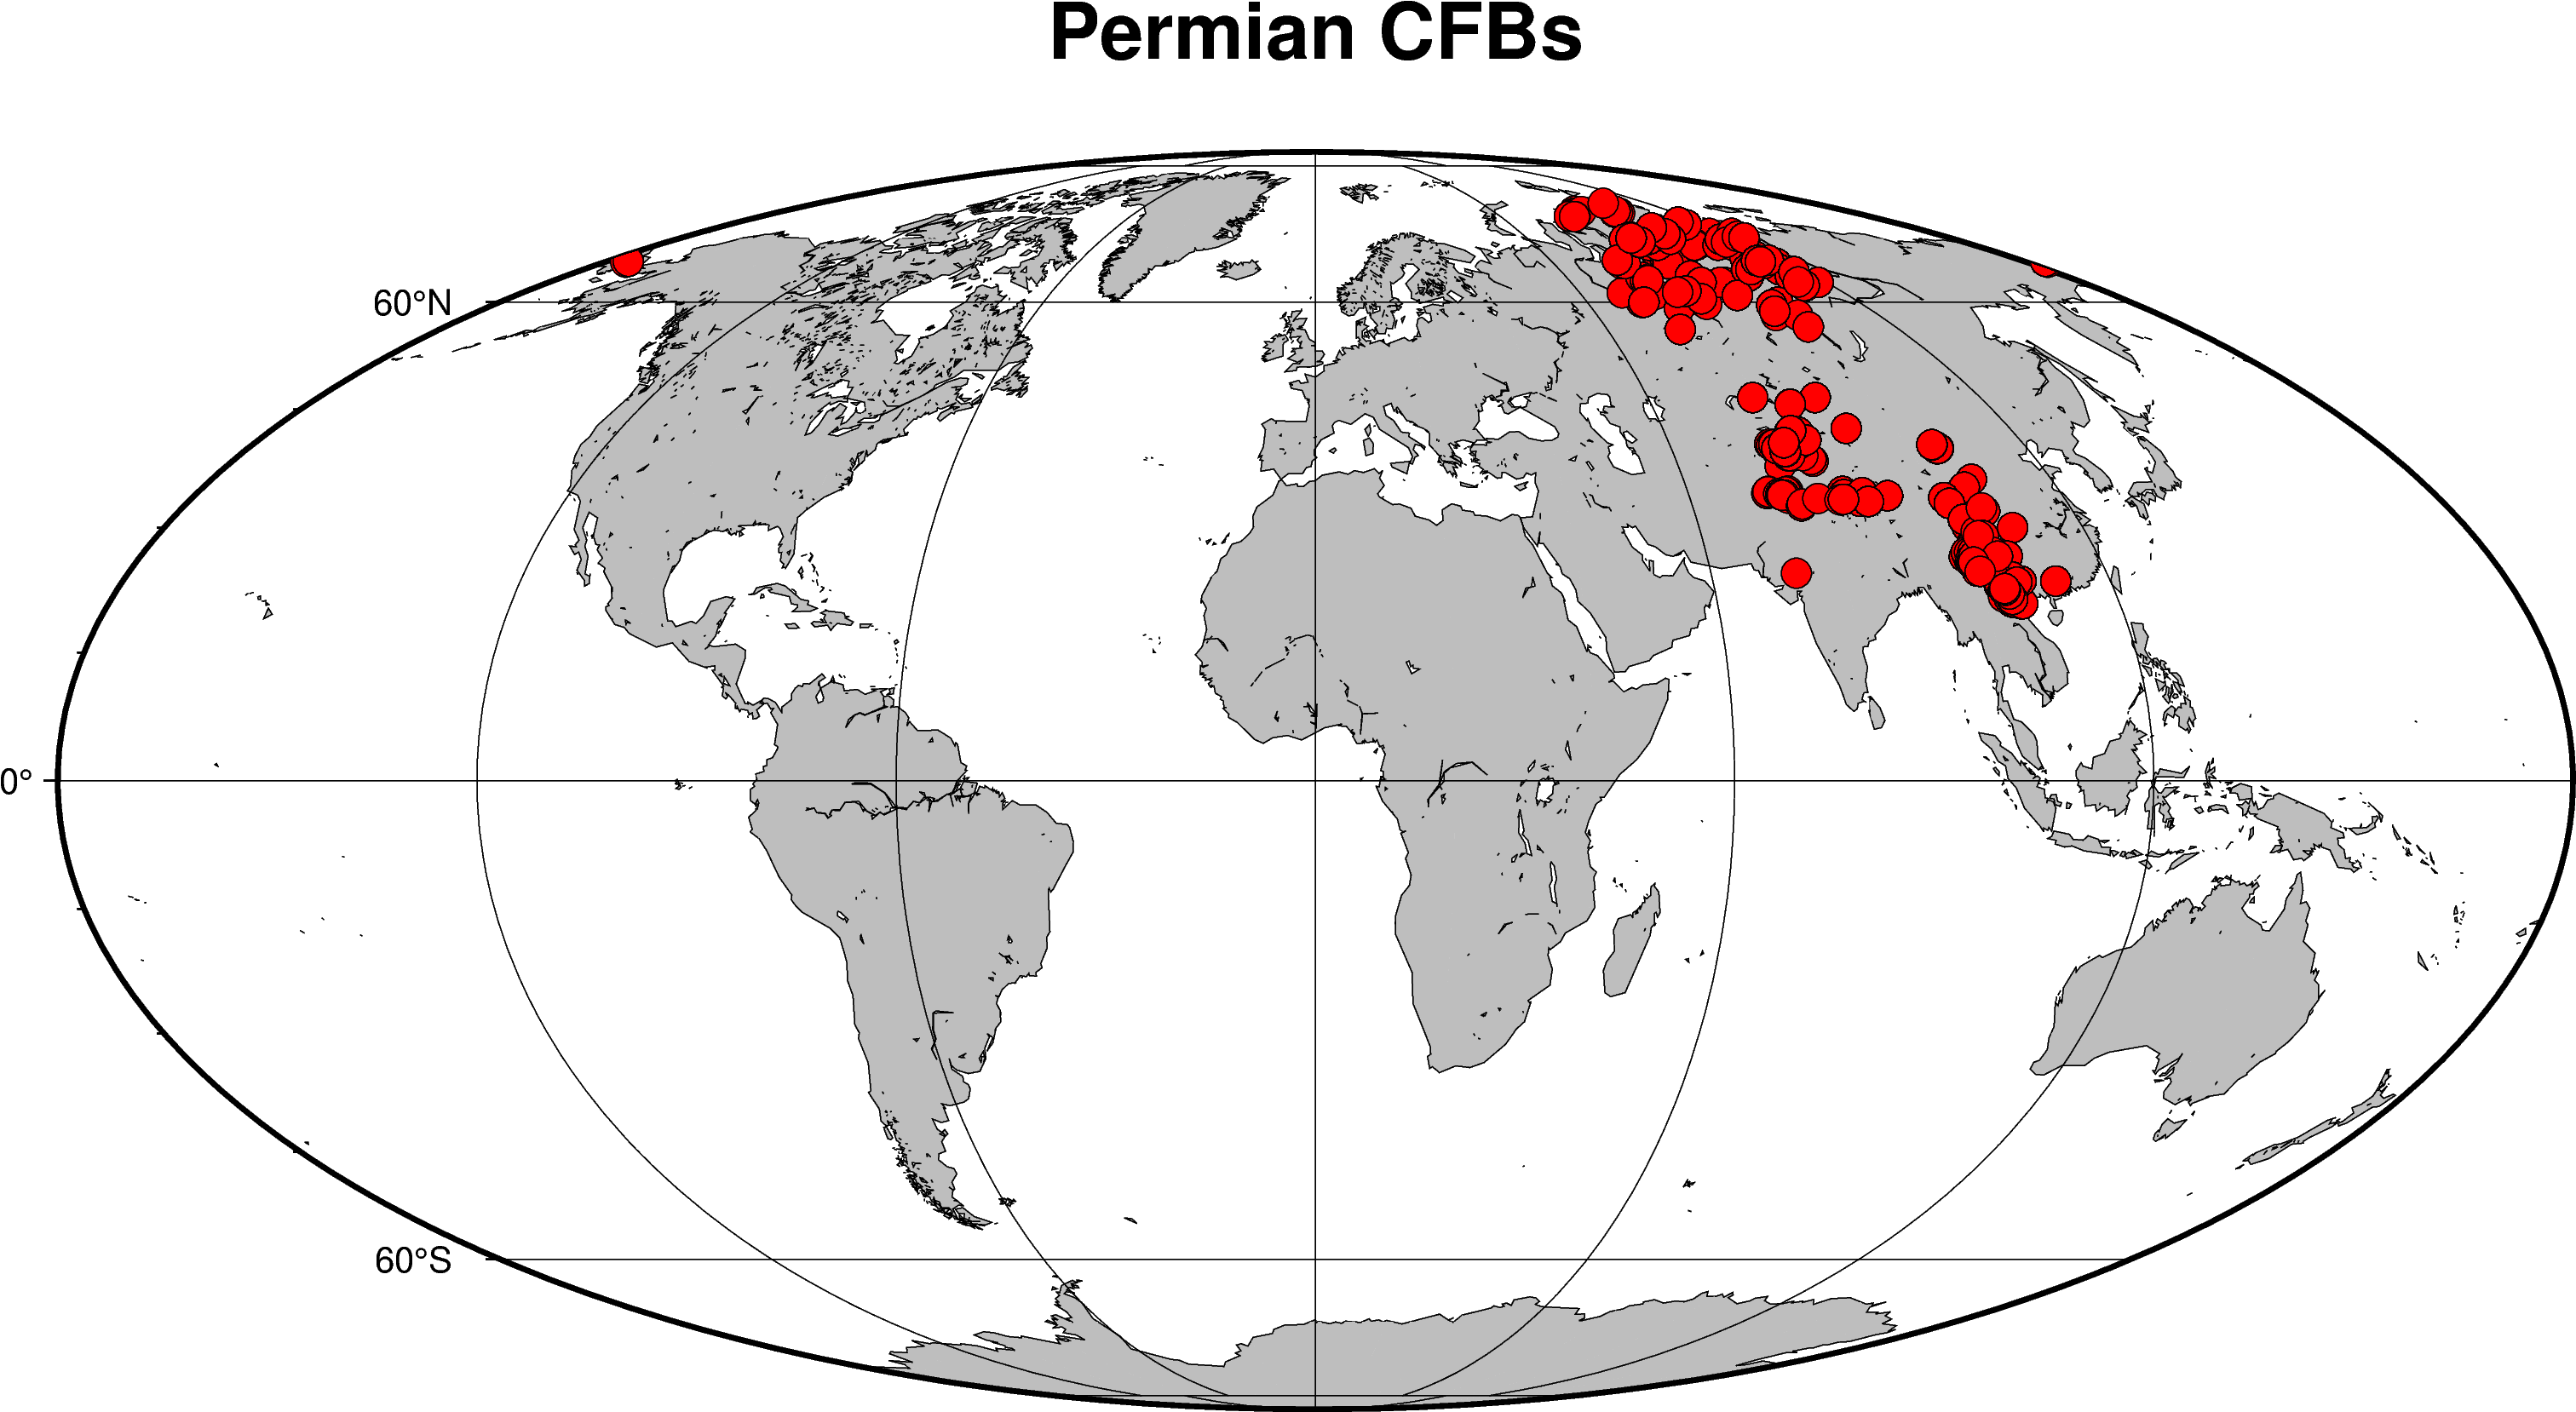

In [ ]:
fig = pygmt.Figure()

fig.coast(
    region="d",
    projection="W25c",
    frame=["afg","+tPermian CFBs"],
    land="gray",
    shorelines="thinnest"
)

fig.plot(
    CFB,
    style="c0.3c",
    fill="red",
    pen="thinnest"
)

fig.show()

We create a new object that associates the point data to the plate reconstruction model to reconstruct the points positions in the desired time

In [ ]:
gpts = gplately.Points(model,CFB.LONGITUDE,CFB.LATITUDE)

In [ ]:
rlons, rlats = gpts.reconstruct(270,return_array=True)
CFB["rlons"] = rlons
CFB["rlats"] = rlats

CFB_pb = CFB.loc[(CFB["PB206_PB204"].notnull()==True)
                 |(CFB["PB207_PB204"].notnull()==True)
                 |(CFB["PB208_PB204"].notnull()==True &(CFB["PB208_PB204"]<41))
                ]


def delta86(row):

    iso208=row["PB208_PB204"]
    iso206=row["PB206_PB204"]

    NHRL = (iso206*1.209)+15.627

    return (iso208-NHRL)*100


CFB_pb["delta86"] = CFB_pb.apply(delta86,axis=1)
CFB_pb = CFB_pb.loc[CFB_pb.delta86.notnull()]

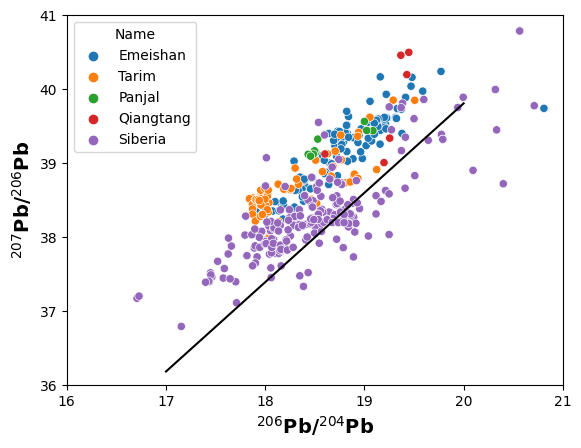

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(
    data=CFB_pb,
    x="PB206_PB204",
    y="PB208_PB204",
    hue="Name",
    ax=ax
)

ax.plot(
    np.arange(17,21),
    (np.arange(17,21) * 1.209) + 15.627,
    ls="-",
    color="k"
)

ax.set_xlabel(r'$^{206}$Pb/$^{204}$Pb', fontsize=14, fontweight='bold')
ax.set_ylabel(r'$^{208}$Pb/$^{206}$Pb', fontsize=14, fontweight='bold')

ax.set(xlim=(16,21), ylim=(36,41))

plt.show()


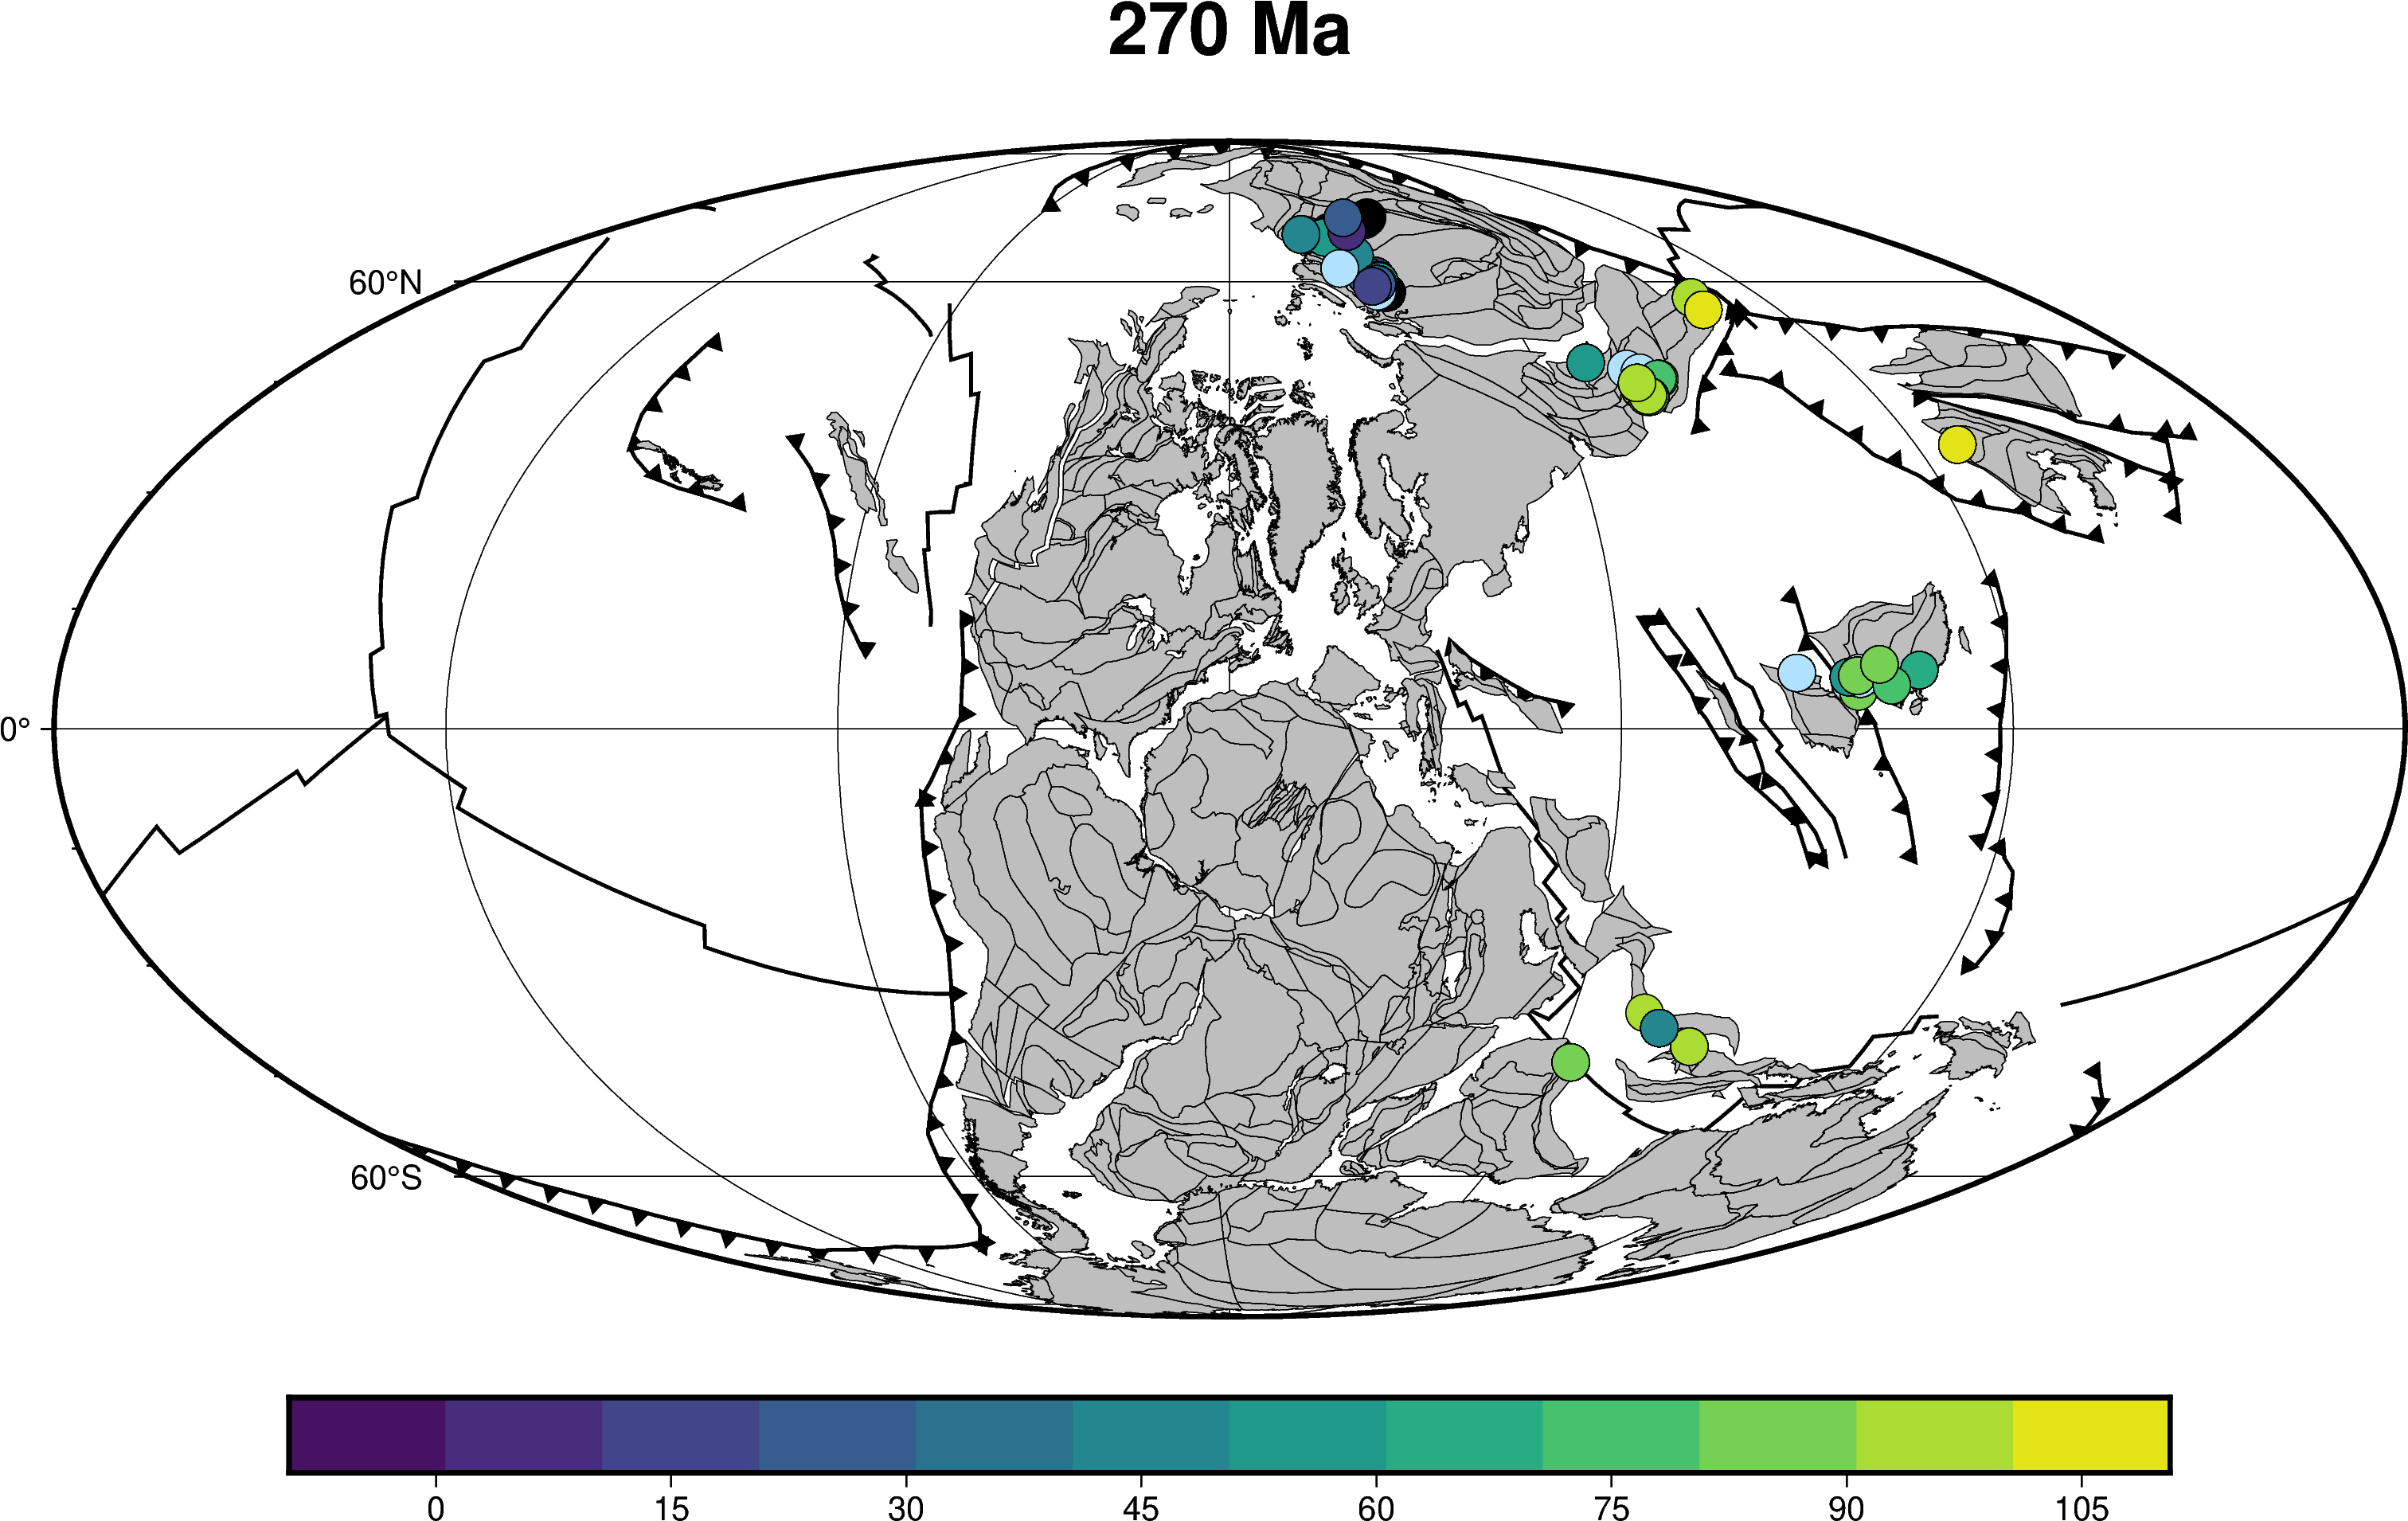

In [ ]:
fig = pygmt.Figure()

pygmt.config(COLOR_FOREGROUND="lightskyblue1")

fig.plot(
    RT.geometry,
    pen="1p,black",
    region="d",
    projection="W25c",
    frame=["afg",f"+t{time} Ma"]
)


plot_subduction(SZ_L,fig)
plot_subduction(SZ_R,fig,side="r")



fig.plot(
    coastlines,
    fill="gray",
    pen="thinnest"

)

pygmt.makecpt(cmap="viridis",series=[CFB_pb.delta86.quantile(0.1),CFB_pb.delta86.quantile(0.9),10])


fig.plot(
    x=CFB_pb.rlons,y=CFB_pb.rlats,
    style="c0.4c",
    fill=CFB_pb.delta86,
    cmap=True,
    pen="thinnest"
)

fig.colorbar(frame=["a15"])


fig.show()

# Plate Tectonic Statistics
When we work with topologies in the full-plate models, we can access relevant statistics that can be used to associate geologic data with tectonic processes. In the following example, we will analyse the position of the subduction zone beneath South America since the Cretaceous and see how subduction speed changed and if that correlates to geochemical indicators.

To access the statistics about the subduction zones, we will use the `model.tessellate_subduction_zones()` function at different time intervals. This function returns the stats about segments of the convergent segments in a numpy array.

The first step will be defining a helper function to transform the numpy array into a pandas DataFrame with named columns

In [ ]:
def DataFramer(subduction_data,t):

    sub_info = pd.DataFrame({
        "Lon":subduction_data.T[0],
        "Lat":subduction_data.T[1],
        "Subducting convergence velocity magnitude":subduction_data.T[2],
        "Subducting convergence obliquity":subduction_data.T[3],
        "trench aboslute velocity magnitude":subduction_data.T[4],
        "trench aboslute velocity obliquity":subduction_data.T[5],
        "length of arc segment":subduction_data.T[6],
        "trench normal azimuth angle":subduction_data.T[7],
        "subducting plate ID":subduction_data.T[8],
        "trench plate ID":subduction_data.T[9],
        "Time":np.full(len(subduction_data),t)
    })


    return sub_info



In [ ]:
sub = []
RT = []
for t in np.arange(0,161,1):
    sub.append(
        DataFramer(model.tessellate_subduction_zones(t, ignore_warnings=True),t)
    )
    if t%40 == 0:
      RT.append(model.tessellate_mid_ocean_ridges(t,ignore_warnings=True))

# concatenate all of the DataFrames into a master DataFrame
SubductionZones = pd.concat(sub)

Next, we filter the DataFrame to only contain points with the South American (or West Gondwana in the past) plate as the overriding plate

In [ ]:
AndesIDs = [201,701]
SubductionZones_fltrd = SubductionZones.loc[SubductionZones["trench plate ID"].isin(AndesIDs)]

In [ ]:
np.linspace(0,81,5)

array([ 0.  , 20.25, 40.5 , 60.75, 81.  ])

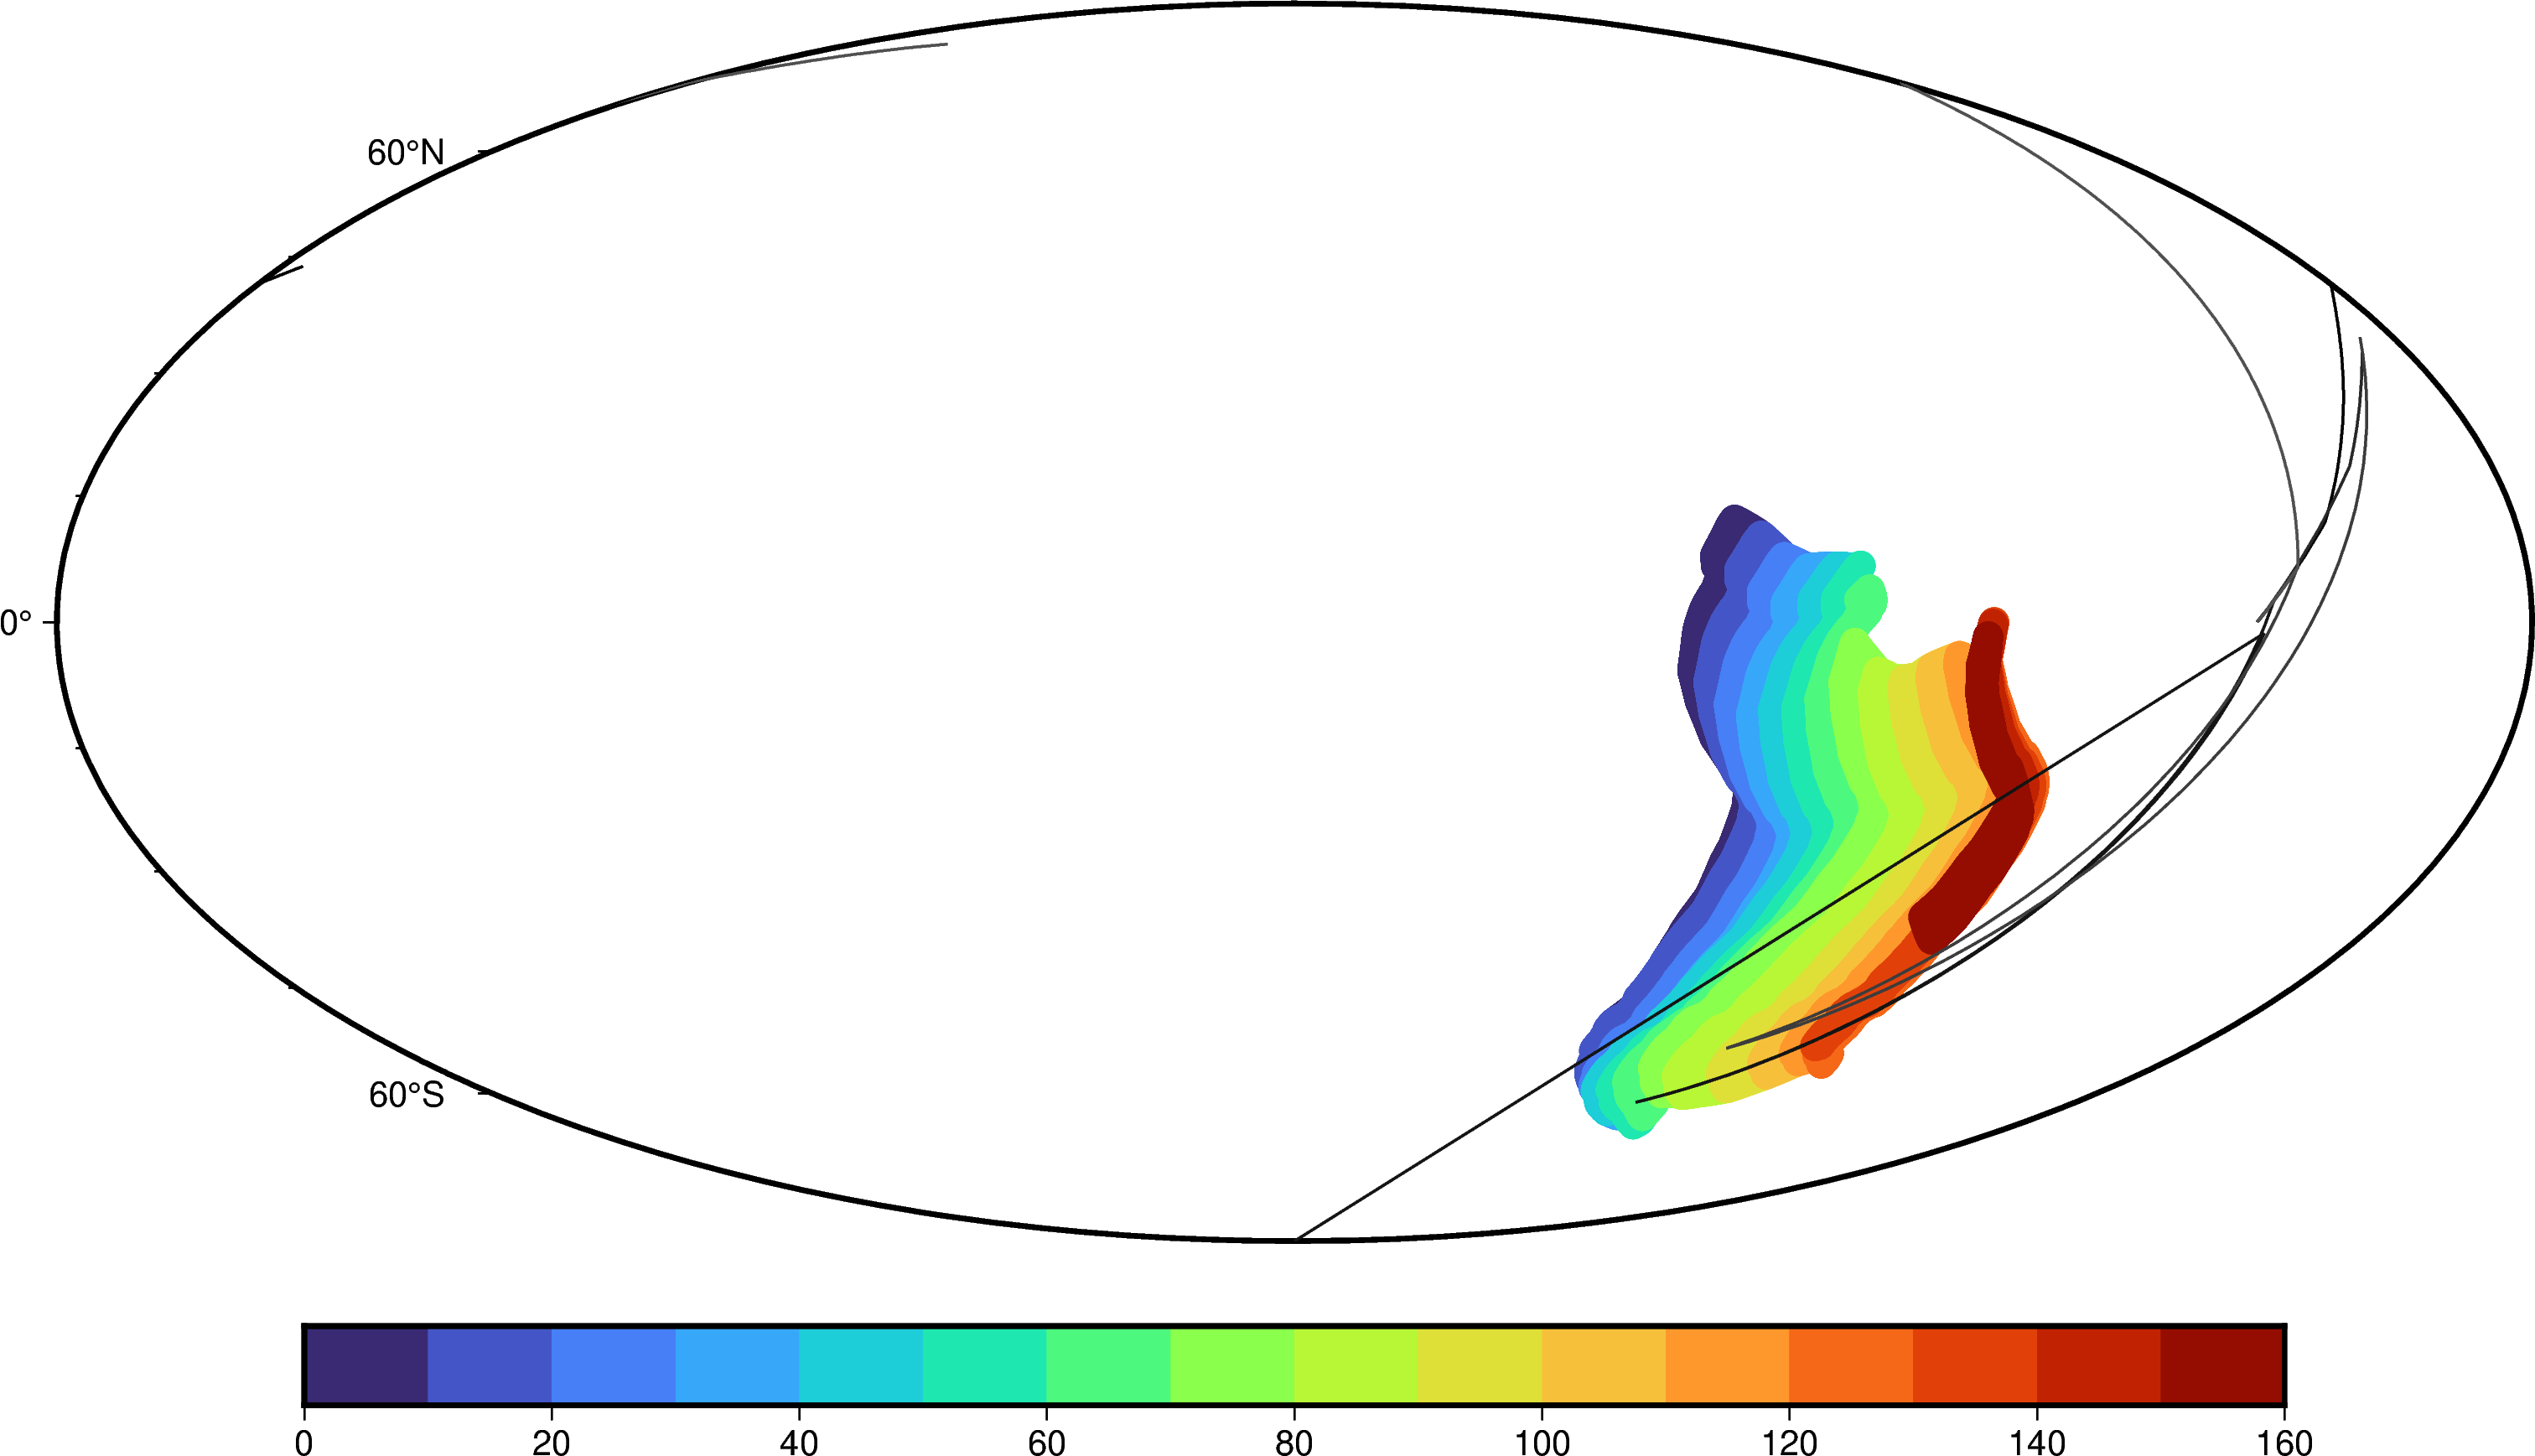

In [ ]:
fig = pygmt.Figure()

fig.basemap(
    projection="W-140/25c",
    region="d",
    frame="af"
)

fig.coast(shorelines="thinnest")

pygmt.makecpt(cmap="turbo",series=[0,160,10])
fig.plot(
    x=SubductionZones_fltrd.Lon,
    y=SubductionZones_fltrd.Lat,
    style="c0.3c",
    fill=SubductionZones_fltrd.Time,
    cmap=True
)




fig.colorbar(frame=["a20","+tTime (Ma)"])




fig.show()

Next we can group all segments of the same time interval using the `DataFrame.groupby()` method. In this instance, we are grouping by "Time" and obtaining the mean value of the "Subducting convergence velocity magnitude" variable

Text(0, 0.5, 'Velocity [cm/yr]')

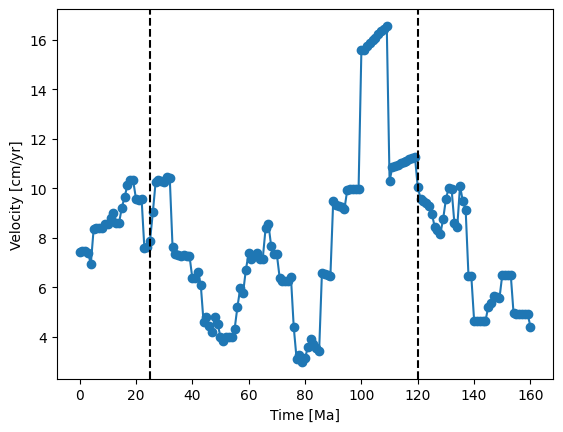

In [ ]:
velocities = SubductionZones_fltrd.groupby("Time")['Subducting convergence velocity magnitude'].mean()

ax = plt.subplot()
ax.plot(
    velocities.index,
    velocities.values
)

ax.scatter(
    velocities.index,
    velocities.values
)
ax.axvline(25,ls="--",color="k")
ax.axvline(120,ls="--",color="k")


ax.set_xlabel("Time [Ma]")
ax.set_ylabel("Velocity [cm/yr]")